In [1]:
import pandas as pd

In [2]:
!ls ../data/preprocessed/*.csv

../data/preprocessed/fbcommenters.csv
../data/preprocessed/fbworkouts_clean.csv
../data/preprocessed/fbworkouts_meta.csv
../data/preprocessed/user_item_interactions.csv


In [3]:
df = pd.read_csv('../data/preprocessed/user_item_interactions.csv')
df.sample(5)

,user_id,workout_id
31767,2457,60
10423,772,284
34256,2648,112
31771,2457,123
11390,851,23


In [4]:
# all are positive samples
df['interacted'] = 1

In [5]:
train_index = df.sample(round(len(df)*0.67)).index
train = df.loc[train_index].copy()
test = df.drop(train_index).copy()

In [23]:
from collections import defaultdict

usersPerWorkout = defaultdict(list)
workoutsPerUser = defaultdict(list)

all_users = set()
all_workouts = set()

# changed to df
for i in df.iterrows():
    usersPerWorkout[i[1]['user_id']].append(i[1]['workout_id'])
    workoutsPerUser[i[1]['workout_id']].append(i[1]['user_id'])
    all_users.add(i[1]['user_id'])
    all_workouts.add(i[1]['workout_id'])

In [24]:
# generate negative samples for validation set
import numpy as np

# changed to df
for i in df.iterrows():
    # find users but this user
    users_not_user = list(all_users - set([i[1]['user_id']]))
    
    # pick one
    not_this_user = np.random.choice(users_not_user)
    
    # find the workouts the one interacted with
    workouts_not_this_user = list(all_workouts - set(workoutsPerUser[not_this_user]))
    
    # choose one
    workout = np.random.choice(workouts_not_this_user, replace=False)
    
    # append
    df = df.append({'user_id': not_this_user, 'workout_id': workout, 'interacted': 0}, ignore_index=True)

In [25]:
import numpy as np

def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    res = numer / denom
    return res

jac_similar = {}

In [26]:
from scipy.spatial import distance
from sklearn.metrics import f1_score
from tqdm import tqdm

ns = []
scores = []

for thres in tqdm(range(0, 3, 1)):
    pred = []
    played = test['interacted']

    for i in test.iterrows():
        u = i[1]['user_id']
        g = i[1]['workout_id']

        # whether this user is close to the users of the game?

        # ---------- in terms of played games
            
        # users (in the training set) who have played g
        users_who_played_g = usersPerWorkout[g]
        
        # all training items user u has played
        games_u_played = workoutsPerUser[u]
        
        # users in training who have played g'
        users_played_games_u_played = [usersPerWorkout[game] for game in games_u_played]
        
        similar = []

        for j in range(len(games_u_played)):
            if (games_u_played[j], g) in jac_similar:
                similar.append(jac_similar[(games_u_played[j], g)])
                
            elif (g, games_u_played[j]) in jac_similar:
                similar.append(jac_similar[(g, games_u_played[j])])
                
            else:
                temp = Jaccard(set(users_who_played_g), set(users_played_games_u_played[j]))
                jac_similar[(games_u_played[j], g)] = temp
                similar.append(temp)

        if (len(similar) > 0 and np.max(similar) > thres/100):
            pred.append(1)
        else:
            pred.append(0)
    
    ns.append(thres/100)
    scores.append(np.mean(np.array(pred) == np.array(played)))

100%|██████████| 3/3 [00:10<00:00,  3.45s/it]


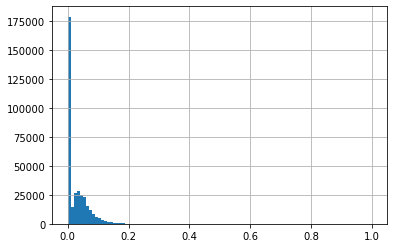

In [27]:
pd.Series(jac_similar.values()).hist(bins=100);

In [28]:
scores

[0.5061103351955307, 0.5060812383612663, 0.5060230446927374]